In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Load California Housing Prices dataset
data = fetch_california_housing()
X = data['data']
y = data['target']

# Preprocess the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

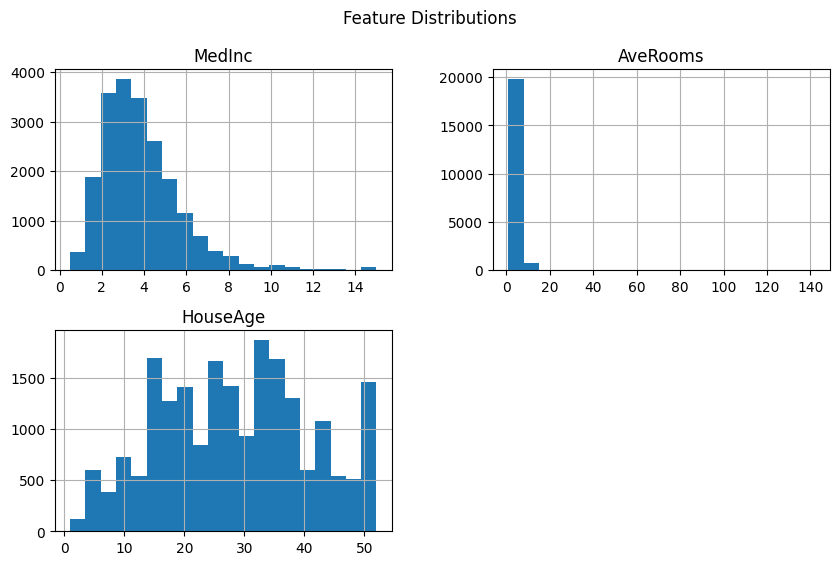

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dataset to DataFrame for visualization
df = pd.DataFrame(X, columns=data['feature_names'])
df['Target'] = y

# Plot histograms for key features
df[['MedInc', 'AveRooms', 'HouseAge']].hist(bins=20, figsize=(10, 6))
plt.suptitle("Feature Distributions")
plt.show()

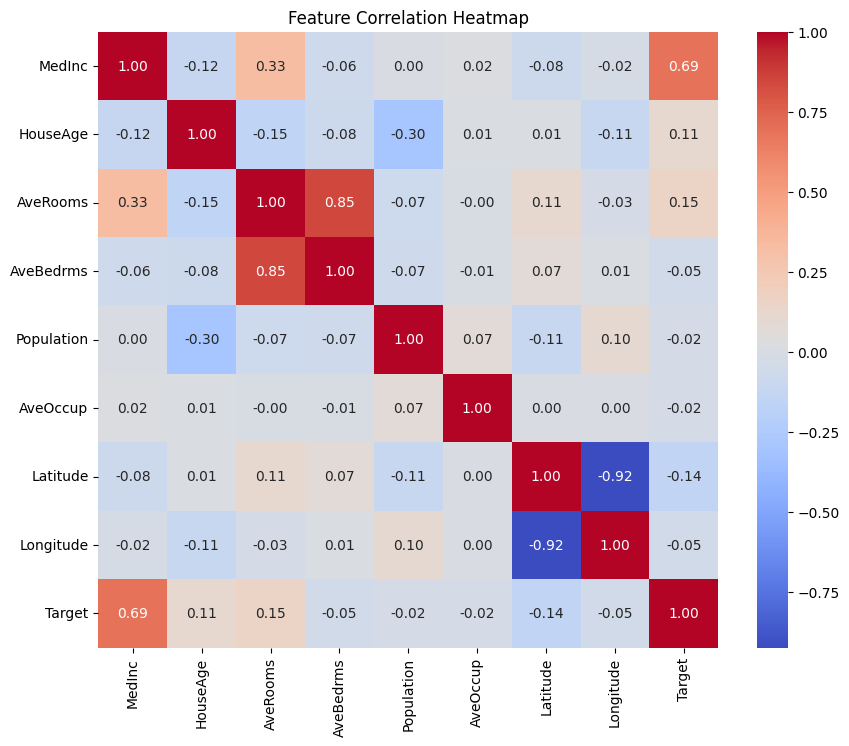

In [31]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [32]:
# Function to build MLP model
def build_mlp(input_dim, depth=1, width=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(width, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    for _ in range(depth - 1):
        model.add(Dense(width, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Single neuron for regression output
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model


# Experiment with varying depths and widths
depths = [1, 3, 5]  # Number of hidden layers
widths = [32, 64, 128]  # Neurons per layer
results = []

for depth in depths:
    for width in widths:
        print(
            f"Training MLP with {depth} hidden layer(s) and {width} neurons per layer...")
        model = build_mlp(
            input_dim=X_train.shape[1], depth=depth, width=width, dropout_rate=0.2)
        history = model.fit(X_train, y_train, validation_split=0.2,
                            epochs=50, batch_size=32, verbose=0)
        val_loss = min(history.history['val_loss'])
        train_loss = history.history['loss']
        results.append((depth, width, val_loss, train_loss))
        print(f"Depth: {depth}, Width: {width}, Validation Loss: {val_loss}")

Training MLP with 1 hidden layer(s) and 32 neurons per layer...
Depth: 1, Width: 32, Validation Loss: 0.36779874563217163
Training MLP with 1 hidden layer(s) and 64 neurons per layer...
Depth: 1, Width: 64, Validation Loss: 0.3514675199985504
Training MLP with 1 hidden layer(s) and 128 neurons per layer...
Depth: 1, Width: 128, Validation Loss: 0.3419022262096405
Training MLP with 3 hidden layer(s) and 32 neurons per layer...
Depth: 3, Width: 32, Validation Loss: 0.3208492696285248
Training MLP with 3 hidden layer(s) and 64 neurons per layer...
Depth: 3, Width: 64, Validation Loss: 0.2855517864227295
Training MLP with 3 hidden layer(s) and 128 neurons per layer...
Depth: 3, Width: 128, Validation Loss: 0.26855483651161194
Training MLP with 5 hidden layer(s) and 32 neurons per layer...
Depth: 5, Width: 32, Validation Loss: 0.3390791118144989
Training MLP with 5 hidden layer(s) and 64 neurons per layer...
Depth: 5, Width: 64, Validation Loss: 0.2999032735824585
Training MLP with 5 hidden

In [33]:
# Convert results to DataFrame for visualization
results_df = pd.DataFrame(
    results, columns=["Depth", "Width", "Validation Loss", "Training Loss"])

In [34]:
# Train the best model and evaluate on the test set
best_model = build_mlp(
    input_dim=X_train.shape[1], depth=3, width=64, dropout_rate=0.2)
best_model.fit(X_train, y_train, validation_split=0.2,
               epochs=50, batch_size=32, verbose=1)
predictions = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse}")
print(f"R-squared: {r2}")

Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 1.0223 - mae: 0.7060 - val_loss: 0.4712 - val_mae: 0.4905
Epoch 2/50
413/413 [==============================] - 2s 4ms/step - loss: 0.5718 - mae: 0.5362 - val_loss: 0.4642 - val_mae: 0.4620
Epoch 3/50
413/413 [==============================] - 1s 4ms/step - loss: 0.5050 - mae: 0.5067 - val_loss: 0.4423 - val_mae: 0.4516
Epoch 4/50
413/413 [==============================] - 1s 3ms/step - loss: 0.4839 - mae: 0.4916 - val_loss: 0.4127 - val_mae: 0.4458
Epoch 5/50
413/413 [==============================] - 1s 3ms/step - loss: 0.4521 - mae: 0.4813 - val_loss: 0.4313 - val_mae: 0.4465
Epoch 6/50
413/413 [==============================] - 1s 3ms/step - loss: 0.4283 - mae: 0.4658 - val_loss: 0.3895 - val_mae: 0.4263
Epoch 7/50
413/413 [==============================] - 1s 3ms/step - loss: 0.4215 - mae: 0.4648 - val_loss: 0.3702 - val_mae: 0.4179
Epoch 8/50
413/413 [==============================] - 1s 3ms/step - loss: 0.

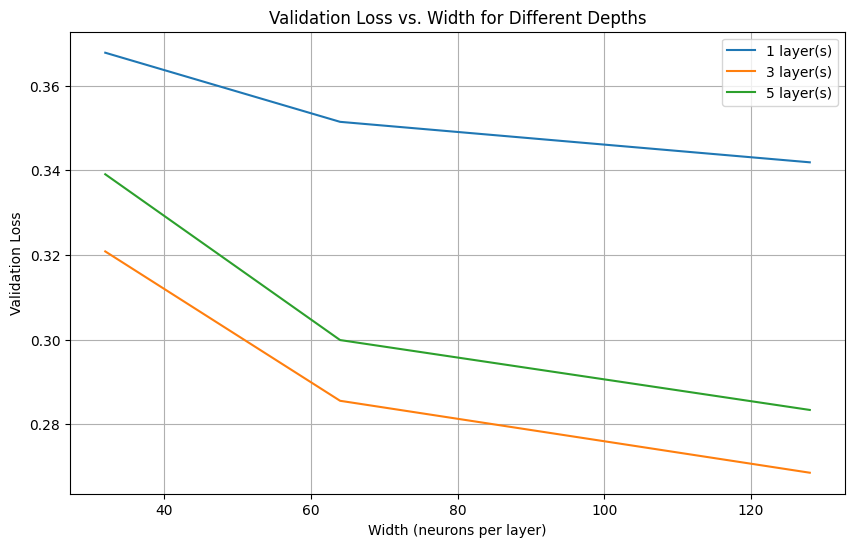

In [35]:
# Plot Validation Loss vs. Width for Different Depths
plt.figure(figsize=(10, 6))
for depth in depths:
    subset = results_df[results_df['Depth'] == depth]
    plt.plot(subset['Width'], subset['Validation Loss'], label=f'{depth} layer(s)')
plt.title("Validation Loss vs. Width for Different Depths")
plt.xlabel("Width (neurons per layer)")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

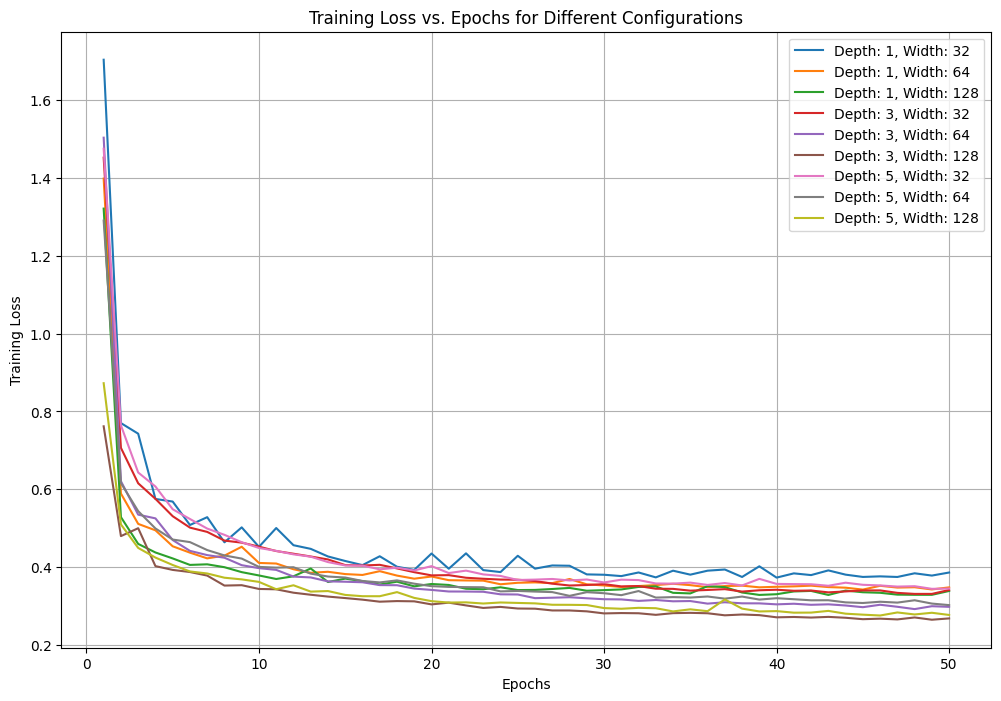

In [36]:
# Plot Training Loss vs. Epochs
plt.figure(figsize=(12, 8))

for idx, row in results_df.iterrows():
    depth = row["Depth"]
    width = row["Width"]
    train_loss = row["Training Loss"]
    plt.plot(range(1, len(train_loss) + 1), train_loss, label=f'Depth: {depth}, Width: {width}')

plt.title("Training Loss vs. Epochs for Different Configurations")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

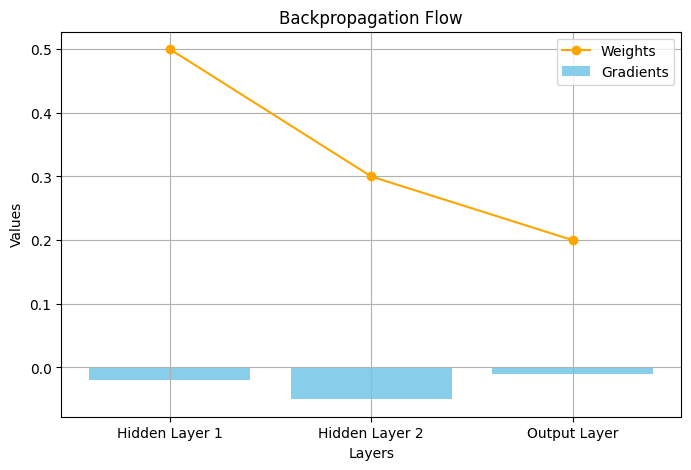

In [37]:
# Example backpropagation visualization
layers = ["Input Layer", "Hidden Layer 1", "Hidden Layer 2", "Output Layer"]
gradients = [-0.02, -0.05, -0.01]
weights = [0.5, 0.3, 0.2]

plt.figure(figsize=(8, 5))
plt.bar(layers[1:], gradients, color='skyblue', label="Gradients")
plt.plot(weights, marker='o', color='orange', label="Weights")
plt.title("Backpropagation Flow")
plt.xlabel("Layers")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

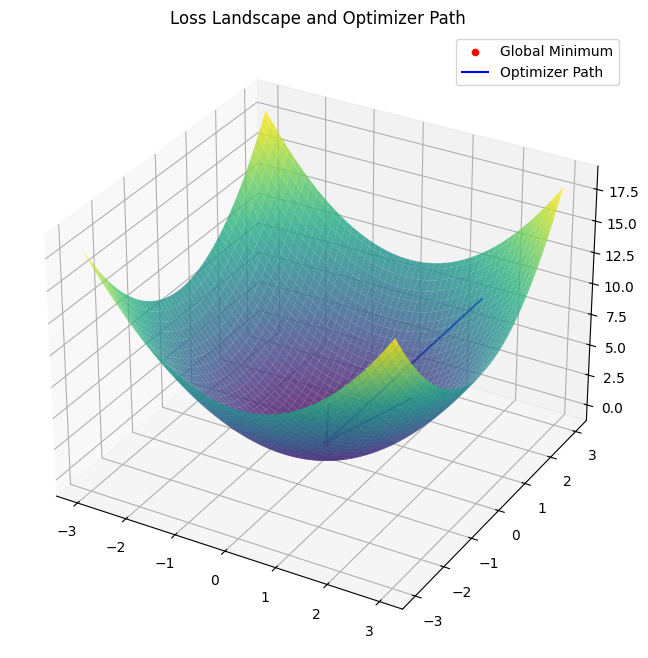

In [38]:
# Loss landscape visualization
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(0, 0, 0, color='red', label='Global Minimum')
ax.quiver(2, 2, 10, -2, -2, -10, color='blue', label='Optimizer Path')
ax.set_title("Loss Landscape and Optimizer Path")
plt.legend()
plt.show()